In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
from PIL import Image
from torchvision.utils import save_image
from torchsummary import summary
from torch.utils.data import Dataset
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import os

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation")

In [7]:
class ImageDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.masks = os.listdir(mask_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = os.path.join(self.image_dir, self.images[idx])
    mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", '.png'))
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

    mask[mask==255.0]==1.0 # convert white pixels to 1

    if self.transform is not None:
      augment = self.transform(image=image, mask=mask)
      image = augment["image"]
      mask = augment["mask"]

    return image, mask

In [8]:
# Hyperparams
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 20
NUM_WORKERS = 2
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 480
PIN_MEMORY = True
LOAD_MODEL = False
IMAGE_DIR = "data/Image"
MASK_DIR = "data/Mask"

In [9]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=25, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2(),],
        is_check_shapes=False)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2(),
    ],
)

In [25]:
def get_loaders(
    IMAGE_DIR,
    MASK_DIR,
    train_transform,
    val_transform,
    BATCH_SIZE,
    NUM_WORKERS,
    PIN_MEMORY,
    shuffle=True,
  ):

  image_ds = ImageDataset(
      image_dir = IMAGE_DIR,
      mask_dir=MASK_DIR,
      transform=train_transform
  )

  loader = DataLoader(
      image_ds,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=True
  )
  return loader

def check_acc(loader, model, device="cuda"):
  correct = 0
  pixels = 0
  dice = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      preds = torch.sigmoid(model(x)['out'])
      preds = (preds>0.5).float()
      correct += (preds==y).sum()
      pixels += torch.numel(preds)
      dice += (2*(preds*y).sum())/((preds+y).sum()+1e-8)
    print("Score:", dice/len(loader))
    model.train()

def save_img(loader, model, save_folder="generated-deeplab", device="cuda"):
  model.eval()
  for idx, (x, y) in enumerate(loader):
    x = x.to(device)
    with torch.no_grad():
      preds = torch.sigmoid(model(x)['out'])
      preds = (preds>0.5).float()

    for i in range(len(preds)):
      save_image(preds[i], f"{save_folder}/preds/pred_{idx}_{i}.png")
      save_image(y[i], f"{save_folder}/targets/target_{idx}_{i}.png")

  model.train()

In [11]:
train_loader = get_loaders(
    IMAGE_DIR,
    MASK_DIR,
    train_transform,
    val_transform,
    BATCH_SIZE,
    NUM_WORKERS,
    PIN_MEMORY,
    shuffle=True,
  )

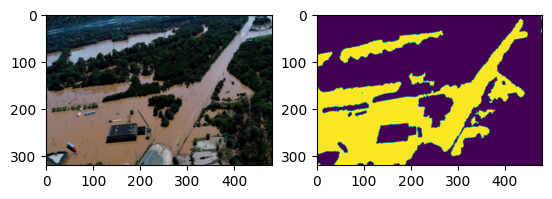

In [12]:
for batch in train_loader:
    images, labels = batch
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(images[0].permute(1, 2, 0).numpy())
    ax[1].imshow(labels[0].numpy())
    plt.show()
    break

In [17]:
def train_loop(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(DEVICE)
    targets = targets.float().unsqueeze(1).to(DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      preds = model(data)['out']
      loss = loss_fn(preds, targets)

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm
    loop.set_postfix(loss=loss.item())

In [15]:
deeplab = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
deeplab.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

deeplab = deeplab.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=deeplab.parameters(), lr=LR) # Create adam optimizer

In [18]:
scaler = torch.cuda.amp.GradScaler()
for epoch in range(NUM_EPOCHS):
  train_loop(train_loader, deeplab, optimizer, loss_fn, scaler)

  # save
  checkpt = {
      "state_dict": deeplab.state_dict(),
      "optim_dict": optimizer.state_dict()
  }

  torch.save(checkpt, "models/deeplab-01.pth.tar")

save_img(train_loader, deeplab)
check_acc(train_loader, deeplab)

100%|██████████| 19/19 [00:15<00:00,  1.19it/s, loss=-839]


TypeError: ignored

In [ ]:
save_img(train_loader, deeplab)


In [ ]:
# Get Dice Scores

import os
import matplotlib.pyplot as plt

def dice_score(mat1, mat2):
  return (2*(mat1*mat2).sum())/(mat1.sum() + mat2.sum())

scores = 0
cnt = 0

image_path = '/content/drive/MyDrive/labrat/DeepLab/generated'
pred_images = os.listdir(os.path.join(image_path, 'preds'))

for pred_img in pred_images:
  temp = pred_img.split('_')

  pred_path = os.path.join(image_path, 'preds', pred_img)
  target_path = os.path.join(image_path, 'targets', f'target_{temp[1]}_{temp[2]}')

  try:
    mat1 = plt.imread(pred_path)
    mat2 = plt.imread(target_path)

    dice = dice_score(mat1, mat2)

    scores += dice
    cnt += 1
  except:
    continue

print('Dice Score (DeepLabV3):', scores/cnt) # 0.86